# Multi modal RAG -  End to end example using Amazon Bedrock Knowledge Bases

Multi-modal RAG can analyze and leverage insights from both textual and visual data, such as images, charts, diagrams, and tables.Bedrock Knowledge Bases offers end-to-end managed Retrieval-Augmented Generation (RAG) workflow that enables customers to create highly accurate, low-latency, secure, and custom generative AI applications by incorporating contextual information from their own data sources.

Bedrock Knowledge Bases extracts content from both text and visual data, generates semantic embeddings using the selected embedding model, and stores them in the chosen vector store. This enables users to retrieve and generate answers to questions derived not only from text but also from visual data. Additionally, retrieved results now include source attribution for visual data, enhancing transparency and building trust in the generated outputs.

You can choose between: Amazon Bedrock Data Automation, a managed service that automatically extracts content from multimodal data (currently in Preview), or FMs such as Claude 3.5 Sonnet or Claude 3 Haiku, with the flexibility to customize the default prompt.

This notebook provides sample code for building a Multimodal RAG using Amazon Bedrock Knowledge Bases.

#### Steps: 
- Create Knowledge Base execution role with necessary policies for accessing/writing data from/to S3 and required Foundation models .
- Create a knowledge base with rich content documents
- Create data source(s) within knowledge base
- Start ingestion jobs using KB APIs which which will read data from the data source, parse the documents (images, charts, tables etc.)using Bedrock Data Automation or Foundation model, chunk it, convert chunks into embeddings using Amazon Titan Embeddings model and then store these embeddings in AOSS. All of this without having to build, deploy and manage the data pipeline.

Once the data is available in the Bedrock Knowledge Base then a question answering application can be built using the Knowledge Base APIs provided by Amazon Bedrock.



#### Pre-requisites:

Please make sure to enable `Anthropic Claude 3 Sonnet` , `Amazon Nova Micro` and  `Titan Text Embeddings V2` model access in Amazon Bedrock Console

<div class="alert alert-block alert-info">
<b>Note:</b> Please run the notebook cell one at a time instead of using "Run All Cells" option.
</div>


### Setup
Before running the rest of this notebook, you'll need to run the cells below to (ensure necessary libraries are installed and) connect to Bedrock.

Please ignore any pip dependency error (if you see any while installing libraries)

In [1]:
%pip install --force-reinstall -q -r ../../requirements.txt --quiet

# %pip install boto3 opensearch-py botocore awscli retrying ragas=0.1.9 ipywidgets  iprogressretrying langchain langchain_aws langchain_community --quiet 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.2 requires botocore<1.35.37,>=1.35.16, but you have botocore 1.35.77 which is incompatible.
apache-beam 2.50.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.50.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.50.0 requires pyarrow<12.0.0,>=3.0.0, but you have pyarrow 18.1.0 which is incompatible.
asyncer 0.0.2 requires anyio<4.0.0,>=3.4.0, but you have anyio 4.7.0 which is incompatible.
chainlit 1.1.402 requires dataclasses_json<0.6.0,>=0.5.7, but you have dataclasses-json 0.6.7 which is incompatible.
chainlit 1.1.402 requires packaging<24.0,>=23.1, but you have packaging 24.2 which is incompatible.
jsii 1.98.0 requires attrs<24.0,>=21.2, but you have attrs 24.2.0 which is incompatible.
langchain-experime

In [2]:
%pip install --upgrade boto3
import boto3
print(boto3.__version__)


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
1.35.77


In [3]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import json
import os
import boto3
from botocore.exceptions import ClientError
import pprint
from utility import create_bedrock_execution_role, create_bedrock_execution_role_multi_ds, create_oss_policy_attach_bedrock_execution_role, create_policies_in_oss, interactive_sleep
import random
from retrying import retry
suffix = random.randrange(200, 900)

sts_client = boto3.client('sts')
boto3_session = boto3.session.Session(region_name = 'us-west-2') # Chage region as required
region_name = boto3_session.region_name

bedrock_agent_client = boto3.client('bedrock-agent', region_name=region_name)
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime', region_name=region_name)

service = 'aoss'
s3_client = boto3.client('s3')
account_id = sts_client.get_caller_identity()["Account"]
s3_suffix = f"{region_name}-{account_id}"


### You can add multiple data sources (S3, Sharepoint) to a multimodal Knowledge Base. For this notebook, we'll test Knowledge Base creation with S3 Bucket.


Each data source may have different pre-requisites, please refer to the AWS documetation for more information.

In [6]:
# For this notebook, we'll create a Knowledge Base with multiple data sources ( 1 S3 bucket, and  1 Sharepoint site)

bucket_name = f'bedrock-mm-kb-{s3_suffix}'
mm_storage_bucket_name = f'bedrock-mm-storage-bucket-{s3_suffix}'

## Please uncomment the data sources that you want to add and update the placeholder values accordingly.

data_sources=[
                {"type": "S3", "bucket_name": bucket_name}, 

                # {"type": "SHAREPOINT", "tenantId": "888d0b57-69f1-4fb8-957f-e1f0bedf64de", "domain": "yourdomain",
                #   "authType": "OAUTH2_CLIENT_CREDENTIALS",
                #  "credentialsSecretArn": f"arn:aws::secretsmanager:{region_name}:secret:<<your_secret_name>>",
                #  "siteUrls": ["https://yourdomain.sharepoint.com/sites/mysite"]
                # },
            ]
                
pp = pprint.PrettyPrinter(indent=2)

In [7]:
# For S3 data source, check if S3 bucket exists, and if not create S3 bucket for knowledge base data source

for ds in [d for d in data_sources if d['type']== 'S3']:
    bucket_name = ds['bucket_name']
    try:
        s3_client.head_bucket(Bucket=bucket_name)
        print(f'Bucket {bucket_name} Exists')
    except ClientError as e:
        print(f'Creating bucket {bucket_name}')
        if region_name == "us-east-1":
               s3_client.create_bucket(
                    Bucket=bucket_name
                )
        else:
            s3_client.create_bucket(
                Bucket=bucket_name,
                CreateBucketConfiguration={'LocationConstraint': region_name}
            )

# For Multi-modal RAG, check if Multimodal storage destination S3 bucket exists, and if not create Multimodal storage destination S3 bucket

try:
    s3_client.head_bucket(Bucket=mm_storage_bucket_name)
    print(f'Bucket {mm_storage_bucket_name} Exists')
except ClientError as e:
    print(f'Creating bucket {mm_storage_bucket_name}')
    if region_name == "us-east-1":
            s3_client.create_bucket(
                Bucket=mm_storage_bucket_name
            )
    else:
        s3_client.create_bucket(
            Bucket=mm_storage_bucket_name,
            CreateBucketConfiguration={'LocationConstraint': region_name}
        )

Bucket bedrock-mm-kb-us-west-2-017444429555 Exists
Bucket bedrock-mm-storage-bucket-us-west-2-017444429555 Exists


## Create a vector store - OpenSearch Serverless index

### Create OSS policies and collection
Firt of all we have to create a vector store. In this section we will use *Amazon OpenSerach serverless.*

Amazon OpenSearch Serverless is a serverless option in Amazon OpenSearch Service. As a developer, you can use OpenSearch Serverless to run large-scale workloads without configuring, managing, and scaling OpenSearch clusters. You get the same interactive millisecond response times as OpenSearch Service with the simplicity of a serverless environment. Pay only for what you use by automatically scaling resources to provide the right amount of capacity for your application—without impacting data ingestion.

In [8]:
import boto3
import time
vector_store_name = f'bedrock-sample-rag-{suffix}'
index_name = f"bedrock-sample-rag-index-{suffix}"
aoss_client = boto3_session.client('opensearchserverless')
bedrock_kb_execution_role = create_bedrock_execution_role_multi_ds(bucket_names=[d["bucket_name"] for d in data_sources if d['type']== 'S3'],
                                secrets_arns = [d["credentialsSecretArn"] for d in data_sources if d['type']== 'CONFLUENCE'or d['type']=='SHAREPOINT' or d['type']=='SALESFORCE'], region = region_name)
bedrock_kb_execution_role_arn = bedrock_kb_execution_role['Role']['Arn']

In [9]:
bedrock_kb_execution_role_arn

'arn:aws:iam::017444429555:role/AmazonBedrockExecutionRoleForKnowledgeBase_306'

#### Update KB execution role

In [10]:
iam = boto3.resource('iam')
client = boto3.client('iam')

def get_attached_policies(role_name):
    response = client.list_attached_role_policies(RoleName=role_name)
    attached_policies = response['AttachedPolicies']
    return attached_policies


role_name = bedrock_kb_execution_role['Role']['RoleName']
attached_policies = get_attached_policies(role_name)
attached_policies

def update_kb_execution_role(attached_policies, mm_storage_bucket_name,region_name):
    
    for policy in attached_policies:

        print(policy['PolicyArn'])
        policy_name = policy['PolicyName']
        policy_arn = policy['PolicyArn']

        if 'S3' in policy_arn:
            print('Updating S3 policy: ',policy_arn)
            policy = iam.Policy(policy_arn)
            version = policy.default_version
            policyJson = version.document
            policyJson['Statement'][0]['Action'].append(f's3:PutObject')  
            policyJson['Statement'][0]['Action'].append(f's3:DeleteObject') 
            policyJson['Statement'][0]['Resource'].append(f'arn:aws:s3:::{mm_storage_bucket_name}')
            policyJson['Statement'][0]['Resource'].append(f'arn:aws:s3:::{mm_storage_bucket_name}/*')
        

            client.detach_role_policy(RoleName=role_name,
                PolicyArn=policy_arn)
            
            response = client.delete_policy(
                PolicyArn=policy_arn
            )
            print(response)
           
            response = client.create_policy(
            PolicyName= policy_name,
            PolicyDocument=json.dumps(policyJson)
            )
            print(response)
        
        client.attach_role_policy(
            RoleName=role_name,
            PolicyArn=policy_arn
        )

In [11]:
# For Parsing/Re-ranking the content - Update attached policies for KB execution role

update_kb_execution_role(attached_policies, mm_storage_bucket_name,region_name)

arn:aws:iam::017444429555:policy/AmazonBedrockS3PolicyForKnowledgeBase_306
Updating S3 policy:  arn:aws:iam::017444429555:policy/AmazonBedrockS3PolicyForKnowledgeBase_306
{'ResponseMetadata': {'RequestId': '8c615aa4-bf2b-4a94-a8dd-c866375b6794', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 10 Dec 2024 00:21:33 GMT', 'x-amzn-requestid': '8c615aa4-bf2b-4a94-a8dd-c866375b6794', 'content-type': 'text/xml', 'content-length': '204'}, 'RetryAttempts': 0}}
{'Policy': {'PolicyName': 'AmazonBedrockS3PolicyForKnowledgeBase_306', 'PolicyId': 'ANPAQID6E33ZXIYVDZLAN', 'Arn': 'arn:aws:iam::017444429555:policy/AmazonBedrockS3PolicyForKnowledgeBase_306', 'Path': '/', 'DefaultVersionId': 'v1', 'AttachmentCount': 0, 'PermissionsBoundaryUsageCount': 0, 'IsAttachable': True, 'CreateDate': datetime.datetime(2024, 12, 10, 0, 21, 34, tzinfo=tzutc()), 'UpdateDate': datetime.datetime(2024, 12, 10, 0, 21, 34, tzinfo=tzutc())}, 'ResponseMetadata': {'RequestId': 'b8d9580e-92dc-4518-8bae-08e7a498227f', 'HTT

In [12]:
# create security, network and data access policies within OSS
encryption_policy, network_policy, access_policy = create_policies_in_oss(vector_store_name=vector_store_name,
                       aoss_client=aoss_client,
                       bedrock_kb_execution_role_arn=bedrock_kb_execution_role_arn)
collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH')

In [13]:
pp.pprint(collection)

{ 'ResponseMetadata': { 'HTTPHeaders': { 'connection': 'keep-alive',
                                         'content-length': '314',
                                         'content-type': 'application/x-amz-json-1.0',
                                         'date': 'Tue, 10 Dec 2024 00:21:35 '
                                                 'GMT',
                                         'x-amzn-requestid': '32f832a5-160a-43bb-8f27-f5f8dfe38379'},
                        'HTTPStatusCode': 200,
                        'RequestId': '32f832a5-160a-43bb-8f27-f5f8dfe38379',
                        'RetryAttempts': 0},
  'createCollectionDetail': { 'arn': 'arn:aws:aoss:us-west-2:017444429555:collection/3qcsa13gza9mywtrzgr3',
                              'createdDate': 1733790095213,
                              'id': '3qcsa13gza9mywtrzgr3',
                              'kmsKeyArn': 'auto',
                              'lastModifiedDate': 1733790095213,
                             

In [14]:
# Get the OpenSearch serverless collection URL
collection_id = collection['createCollectionDetail']['id']
host = collection_id + '.' + region_name + '.aoss.amazonaws.com'
print(host)

3qcsa13gza9mywtrzgr3.us-west-2.aoss.amazonaws.com


In [15]:
import time
# wait for collection creation
# This can take couple of minutes to finish
response = aoss_client.batch_get_collection(names=[vector_store_name])
# Periodically check collection status
while (response['collectionDetails'][0]['status']) == 'CREATING':
    print('Creating collection...')
    interactive_sleep(30)
    response = aoss_client.batch_get_collection(names=[vector_store_name])
print('\nCollection successfully created:')
pp.pprint(response["collectionDetails"])

Creating collection...
..............................
Collection successfully created:
[ { 'arn': 'arn:aws:aoss:us-west-2:017444429555:collection/3qcsa13gza9mywtrzgr3',
    'collectionEndpoint': 'https://3qcsa13gza9mywtrzgr3.us-west-2.aoss.amazonaws.com',
    'createdDate': 1733790095213,
    'dashboardEndpoint': 'https://3qcsa13gza9mywtrzgr3.us-west-2.aoss.amazonaws.com/_dashboards',
    'id': '3qcsa13gza9mywtrzgr3',
    'kmsKeyArn': 'auto',
    'lastModifiedDate': 1733790118223,
    'name': 'bedrock-sample-rag-515',
    'standbyReplicas': 'ENABLED',
    'status': 'ACTIVE',
    'type': 'VECTORSEARCH'}]


In [16]:
# create opensearch serverless access policy and attach it to Bedrock execution role
try:
    create_oss_policy_attach_bedrock_execution_role(collection_id=collection_id,
                                                    bedrock_kb_execution_role=bedrock_kb_execution_role, region = region_name)
    # It can take up to a minute for data access rules to be enforced
    interactive_sleep(30)
except Exception as e:
    print("Policy already exists")
    pp.pprint(e)

Opensearch serverless arn:  arn:aws:iam::017444429555:policy/AmazonBedrockOSSPolicyForKnowledgeBase_306


## Create vector index

In [17]:
# Create the vector index in Opensearch serverless, with the knn_vector field index mapping, specifying the dimension size, name and engine.
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth, RequestError
credentials = boto3.Session().get_credentials()
awsauth = auth = AWSV4SignerAuth(credentials, region_name, service)

index_name = f"bedrock-sample-index-{suffix}"
body_json = {
   "settings": {
      "index.knn": "true",
       "number_of_shards": 1,
       "knn.algo_param.ef_search": 512,
       "number_of_replicas": 0,
   },
   "mappings": {
      "properties": {
         "vector": {
            "type": "knn_vector",
            "dimension": 1024,
             "method": {
                 "name": "hnsw",
                 "engine": "faiss",
                 "space_type": "l2"
             },
         },
         "text": {
            "type": "text"
         },
         "text-metadata": {
            "type": "text"         }
      }
   }
}

# Build the OpenSearch client
oss_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=300
)


In [18]:
# Create index
try:
    response = oss_client.indices.create(index=index_name, body=json.dumps(body_json))
    print('\nCreating index:')
    pp.pprint(response)

    # index creation can take up to a minute
    interactive_sleep(30)
except RequestError as e:
    # you can delete the index if its already exists
    # oss_client.indices.delete(index=index_name)
    print(f'Error while trying to create the index, with error {e.error}\nyou may unmark the delete above to delete, and recreate the index')
    


Creating index:
{ 'acknowledged': True,
  'index': 'bedrock-sample-index-515',
  'shards_acknowledged': True}


## Data Ingestion
We'll use the following data:
 - Multimodal data stored in a local directory as first data source

##### Upload data to S3 Bucket data source

In [19]:
def upload_directory(path, bucket_name):
        for root,dirs,files in os.walk(path):
            for file in files:
                file_to_upload = os.path.join(root,file)
                print(f"uploading file {file_to_upload} to {bucket_name}")
                s3_client.upload_file(file_to_upload,bucket_name,file)

upload_directory("./mm-data", bucket_name)

uploading file ./mm-data/tornadoes.pdf.metadata.json to bedrock-mm-kb-us-west-2-017444429555
uploading file ./mm-data/tornadoes.pdf to bedrock-mm-kb-us-west-2-017444429555
uploading file ./mm-data/us-finance-report-2023-sample.pdf to bedrock-mm-kb-us-west-2-017444429555
uploading file ./mm-data/wildfires.pdf.metadata.json to bedrock-mm-kb-us-west-2-017444429555
uploading file ./mm-data/wildfires.pdf to bedrock-mm-kb-us-west-2-017444429555
uploading file ./mm-data/DI_FSI-Predictions-2023.pdf to bedrock-mm-kb-us-west-2-017444429555
uploading file ./mm-data/evaluating_code_trained_LLM.pdf to bedrock-mm-kb-us-west-2-017444429555


## Create Knowledge Base
Steps:
- initialize Open search serverless configuration which will include collection ARN, index name, vector field, text field and metadata field.
- initialize the Titan embeddings model ARN, as this will be used to create the embeddings for each of the text chunks.

In [20]:
opensearchServerlessConfiguration = {
            "collectionArn": collection["createCollectionDetail"]['arn'],
            "vectorIndexName": index_name,
            "fieldMapping": {
                "vectorField": "vector",
                "textField": "text",
                "metadataField": "text-metadata"
            }
        }

# The embedding model used by Bedrock to embed ingested documents, and realtime prompts
embeddingModelArn = f"arn:aws:bedrock:{region_name}::foundation-model/amazon.titan-embed-text-v2:0"
                    
supplementalStorageLocation= {
                    "storageLocations": [
                    {
                        "s3Location": {
                            "uri": f"s3://{mm_storage_bucket_name}"
                        },
                        "type": "S3"
                    }
                ]
            }
                    
name = f"bedrock-sample-knowledge-base-{suffix}"
description = "Multi-modal RAG knowledge base."

roleArn = bedrock_kb_execution_role_arn


In [21]:
print(opensearchServerlessConfiguration)

{'collectionArn': 'arn:aws:aoss:us-west-2:017444429555:collection/3qcsa13gza9mywtrzgr3', 'vectorIndexName': 'bedrock-sample-index-515', 'fieldMapping': {'vectorField': 'vector', 'textField': 'text', 'metadataField': 'text-metadata'}}


In [22]:
roleArn

'arn:aws:iam::017444429555:role/AmazonBedrockExecutionRoleForKnowledgeBase_306'

Provide the above configurations as input to the `create_knowledge_base` method, which will create the Knowledge base.

In [23]:
# Create a KnowledgeBase
from retrying import retry

@retry(wait_random_min=1000, wait_random_max=2000,stop_max_attempt_number=7)
def create_knowledge_base_func():
    create_kb_response = bedrock_agent_client.create_knowledge_base(
        name = name,
        description = description,
        roleArn = roleArn,
        knowledgeBaseConfiguration = {
            "type": "VECTOR",
            "vectorKnowledgeBaseConfiguration": {
                "embeddingModelArn": embeddingModelArn,
                # "embeddingModelConfiguration": {
                #     "bedrockEmbeddingModelConfiguration": {
                #         "dimensions": 1024,
                #         "embeddingDataType": "null"
                #     }
                # },
                "supplementalDataStorageConfiguration": supplementalStorageLocation
            }
        },
        storageConfiguration = {
            "type": "OPENSEARCH_SERVERLESS",
            "opensearchServerlessConfiguration":opensearchServerlessConfiguration
        }
    )
    
    return create_kb_response["knowledgeBase"]

In [24]:
try:
    kb = create_knowledge_base_func()
except Exception as err:
    print(f"{err=}, {type(err)=}")

In [25]:
pp.pprint(kb)

{ 'createdAt': datetime.datetime(2024, 12, 10, 0, 23, 17, 763123, tzinfo=tzutc()),
  'description': 'Multi-modal RAG knowledge base.',
  'knowledgeBaseArn': 'arn:aws:bedrock:us-west-2:017444429555:knowledge-base/3QNKYFDFSE',
  'knowledgeBaseConfiguration': { 'type': 'VECTOR',
                                  'vectorKnowledgeBaseConfiguration': { 'embeddingModelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-embed-text-v2:0',
                                                                        'supplementalDataStorageConfiguration': { 'storageLocations': [ { 's3Location': { 'uri': 's3://bedrock-mm-storage-bucket-us-west-2-017444429555'},
                                                                                                                                          'type': 'S3'}]}}},
  'knowledgeBaseId': '3QNKYFDFSE',
  'name': 'bedrock-sample-knowledge-base-515',
  'roleArn': 'arn:aws:iam::017444429555:role/AmazonBedrockExecutionRoleForKnowledgeBase_306',
  

In [26]:
# Get KnowledgeBase 
get_kb_response = bedrock_agent_client.get_knowledge_base(knowledgeBaseId = kb['knowledgeBaseId'])

Next we need to create data source(s), which will be associated with the knowledge base created above. Once the data source(s) is ready, we can then start to ingest the documents.

## Create Data Source(s)
Steps:
- initialize chunking strategy, based on which KB will split the documents into pieces of size equal to the chunk size mentioned in the `chunkingStrategyConfiguration`.
- initialize the s3 configuration, which will be used to create the data source object later.
- initialize the Parsing configuration, which will used to parse the data from source document.

NOTE: In the current sample,
-   1. we'll use FIXED_SIZE chunking Strategy but you can also use other chunking chunking strategies like HIERARCHICAL, SEMANTIC or NONE. For more details on the chunking startegies please refer to the [AWS documentation page](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_agent_ChunkingConfiguration.html)
-   2. we'll use BEDROCK_DATA_AUTOMATION as parsing strategy. For foundation models selection, you have choice of using  You can also use BEDROCK_FOUNDATION_MODEL as parsing strategy. Please refer to the [AWS documentation page](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_agent_ParsingConfiguration.html)

In [27]:
# Function to create KB
def create_ds(data_sources):
    ds_list=[]
    for idx, ds in enumerate(data_sources):
        # Ingest strategy - How to ingest data from the data source
        chunkingStrategyConfiguration = {
            "chunkingStrategy": "FIXED_SIZE", 
            "fixedSizeChunkingConfiguration": {
                "maxTokens": 512,
                "overlapPercentage": 20
            }
        }
        
        # The data source to ingest documents from, into the OpenSearch serverless knowledge base index
        
        s3DataSourceConfiguration = {
                "type": "S3",
                "s3Configuration":{
                    "bucketArn": "",
                    # "inclusionPrefixes":["*.*"] # you can use this if you want to create a KB using data within s3 prefixes.
                    }
            }
        
        # Parsing configuration for parsing document
        parsingConfiguration = {
           
                ## If using BDA - uncomment below
                ##---------------------------------
                
                # "bedrockDataAutomationConfiguration": {
                #     "parsingModality": "MULTIMODAL"
                # },
                # "parsingStrategy": "BEDROCK_DATA_AUTOMATION"

                ## If using Foundatopn Model Parser
                ##----------------------------------

                "bedrockFoundationModelConfiguration": {
                    "parsingModality": "MULTIMODAL",
                    "modelArn": f"arn:aws:bedrock:{region_name}::foundation-model/anthropic.claude-3-sonnet-20240229-v1:0"
                },
                "parsingStrategy": "BEDROCK_FOUNDATION_MODEL"
            }
        

        # Set the data source configuration based on the Data source type

        if ds['type'] == "S3":
            print(f'{idx +1 } data source: S3')
            ds_name = f'{name}-{bucket_name}'
            s3DataSourceConfiguration["s3Configuration"]["bucketArn"] = f'arn:aws:s3:::{ds["bucket_name"]}'
            # print(s3DataSourceConfiguration)
            data_source_configuration = s3DataSourceConfiguration
        
            
        # Create a DataSource in KnowledgeBase 
        create_ds_response = bedrock_agent_client.create_data_source(
            name = ds_name,
            description = description,
            knowledgeBaseId = kb['knowledgeBaseId'],
            dataSourceConfiguration = data_source_configuration,
            vectorIngestionConfiguration = {
                "chunkingConfiguration": chunkingStrategyConfiguration,
                "parsingConfiguration": parsingConfiguration
            }
        )
        ds = create_ds_response["dataSource"]
        pp.pprint(ds)
        ds_list.append(ds)
    return ds_list

In [28]:
data_sources_list = create_ds(data_sources)

1 data source: S3
{ 'createdAt': datetime.datetime(2024, 12, 10, 0, 23, 19, 10841, tzinfo=tzutc()),
  'dataDeletionPolicy': 'DELETE',
  'dataSourceConfiguration': { 's3Configuration': { 'bucketArn': 'arn:aws:s3:::bedrock-mm-kb-us-west-2-017444429555'},
                               'type': 'S3'},
  'dataSourceId': 'XRQ1IQRYSG',
  'description': 'Multi-modal RAG knowledge base.',
  'knowledgeBaseId': '3QNKYFDFSE',
  'name': 'bedrock-sample-knowledge-base-515-bedrock-mm-kb-us-west-2-017444429555',
  'status': 'AVAILABLE',
  'updatedAt': datetime.datetime(2024, 12, 10, 0, 23, 19, 10841, tzinfo=tzutc()),
  'vectorIngestionConfiguration': { 'chunkingConfiguration': { 'chunkingStrategy': 'FIXED_SIZE',
                                                               'fixedSizeChunkingConfiguration': { 'maxTokens': 512,
                                                                                                   'overlapPercentage': 20}},
                                    'parsingConfigu

In [29]:
data_sources_list

[{'createdAt': datetime.datetime(2024, 12, 10, 0, 23, 19, 10841, tzinfo=tzutc()),
  'dataDeletionPolicy': 'DELETE',
  'dataSourceConfiguration': {'s3Configuration': {'bucketArn': 'arn:aws:s3:::bedrock-mm-kb-us-west-2-017444429555'},
   'type': 'S3'},
  'dataSourceId': 'XRQ1IQRYSG',
  'description': 'Multi-modal RAG knowledge base.',
  'knowledgeBaseId': '3QNKYFDFSE',
  'name': 'bedrock-sample-knowledge-base-515-bedrock-mm-kb-us-west-2-017444429555',
  'status': 'AVAILABLE',
  'updatedAt': datetime.datetime(2024, 12, 10, 0, 23, 19, 10841, tzinfo=tzutc()),
  'vectorIngestionConfiguration': {'chunkingConfiguration': {'chunkingStrategy': 'FIXED_SIZE',
    'fixedSizeChunkingConfiguration': {'maxTokens': 512,
     'overlapPercentage': 20}},
   'parsingConfiguration': {'bedrockFoundationModelConfiguration': {'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/anthropic.claude-3-sonnet-20240229-v1:0',
     'parsingModality': 'MULTIMODAL'},
    'parsingStrategy': 'BEDROCK_FOUNDATION_MODEL'

In [30]:
# Get DataSource 
for idx, ds in enumerate(data_sources_list):
    print(bedrock_agent_client.get_data_source(knowledgeBaseId = kb['knowledgeBaseId'], dataSourceId = ds["dataSourceId"]))
    print(" ")

{'ResponseMetadata': {'RequestId': '78084537-cd20-41cb-b062-5b1d810c3d1a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 10 Dec 2024 00:23:19 GMT', 'content-type': 'application/json', 'content-length': '871', 'connection': 'keep-alive', 'x-amzn-requestid': '78084537-cd20-41cb-b062-5b1d810c3d1a', 'x-amz-apigw-id': 'CjJ-rHPCPHcEPBw=', 'x-amzn-trace-id': 'Root=1-675789f7-2598050976ef841d73351f4b'}, 'RetryAttempts': 0}, 'dataSource': {'createdAt': datetime.datetime(2024, 12, 10, 0, 23, 19, 10841, tzinfo=tzutc()), 'dataDeletionPolicy': 'DELETE', 'dataSourceConfiguration': {'s3Configuration': {'bucketArn': 'arn:aws:s3:::bedrock-mm-kb-us-west-2-017444429555'}, 'type': 'S3'}, 'dataSourceId': 'XRQ1IQRYSG', 'description': 'Multi-modal RAG knowledge base.', 'knowledgeBaseId': '3QNKYFDFSE', 'name': 'bedrock-sample-knowledge-base-515-bedrock-mm-kb-us-west-2-017444429555', 'status': 'AVAILABLE', 'updatedAt': datetime.datetime(2024, 12, 10, 0, 23, 19, 10841, tzinfo=tzutc()), 'vectorIngestionCo

### Start ingestion job
Once the KB and data source(s) created, we can start the ingestion job for each data source.
During the ingestion job, KB will fetch the documents from the data source, Parse the document to extract text, chunk it based on the chunking size provided, create embeddings of each chunk and then write it to the vector database, in this case OSS.

NOTE: Currently, you can only kick-off one ingestion job at one time.

In [31]:
interactive_sleep(30)
ingest_jobs=[]
# Start an ingestion job
for idx, ds in enumerate(data_sources_list):
    try:
        start_job_response = bedrock_agent_client.start_ingestion_job(knowledgeBaseId = kb['knowledgeBaseId'], dataSourceId = ds["dataSourceId"])
        job = start_job_response["ingestionJob"]
        print(f"job {idx} started successfully\n")
    
        while job['status'] not in ["COMPLETE", "FAILED", "STOPPED"]:
            get_job_response = bedrock_agent_client.get_ingestion_job(
              knowledgeBaseId = kb['knowledgeBaseId'],
                dataSourceId = ds["dataSourceId"],
                ingestionJobId = job["ingestionJobId"]
          )
            job = get_job_response["ingestionJob"]
        pp.pprint(job)
        interactive_sleep(40)

        ingest_jobs.append(job)
    except Exception as e:
        print(f"Couldn't start {idx} job.\n")
        print(e)
    
    

job 0 started successfully....

{ 'dataSourceId': 'XRQ1IQRYSG',
  'failureReasons': [ '["Encountered error: Ignored 1 files as their file '
                      'format was not supported. [Files: '
                      's3://bedrock-mm-kb-us-west-2-017444429555/.DS_Store]. '
                      'Call to Customer Source did not succeed."]'],
  'ingestionJobId': 'VB1CVOLLGE',
  'knowledgeBaseId': '3QNKYFDFSE',
  'startedAt': datetime.datetime(2024, 12, 10, 0, 23, 54, 387627, tzinfo=tzutc()),
  'statistics': { 'numberOfDocumentsDeleted': 0,
                  'numberOfDocumentsFailed': 1,
                  'numberOfDocumentsScanned': 6,
                  'numberOfMetadataDocumentsModified': 0,
                  'numberOfMetadataDocumentsScanned': 2,
                  'numberOfModifiedDocumentsIndexed': 0,
                  'numberOfNewDocumentsIndexed': 5},
  'status': 'COMPLETE',
  'updatedAt': datetime.datetime(2024, 12, 10, 0, 30, 37, 186274, tzinfo=tzutc())}


In [32]:
# Print the knowledge base Id in bedrock, that corresponds to the Opensearch index in the collection we created before, we will use it for the invocation later
kb_id = kb["knowledgeBaseId"]
pp.pprint(kb_id)

'3QNKYFDFSE'


In [33]:
# keep the kb_id for invocation later in the invoke request
%store kb_id

Stored 'kb_id' (str)


### 2.2 Test the Knowledge Base
Now the Knowlegde Base is available we can test it out using the [**retrieve**](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve.html) and [**retrieve_and_generate**](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve_and_generate.html) functions. 

#### Testing Knowledge Base with Retrieve and Generate API

Let's first test the knowledge base using the retrieve and generate API. With this API, Bedrock takes care of retrieving the necessary references from the knowledge base and generating the final answer using a foundation model from Bedrock.

query = `When alternative data provider revenue is expected to surpass traditional data provider revenue?`

The right response for this query as per ground truth is: `2029` and this response is expected to fetch from a chart.

In [34]:
query = "When alternative data provider revenue is expected to surpass traditional data provider revenue ?"

In [35]:
roleArn

'arn:aws:iam::017444429555:role/AmazonBedrockExecutionRoleForKnowledgeBase_306'

In [36]:
foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"
# foundation_model = "amazon.nova-micro-v1:0"

response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
        "text": query
    },
    retrieveAndGenerateConfiguration={
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            'knowledgeBaseId': kb_id,
            "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region_name, foundation_model),
            "retrievalConfiguration": {
                "vectorSearchConfiguration": {
                    "numberOfResults":5
                } 
            }
        }
    }
)

print(response['output']['text'],end='\n'*2)

According to the analysis from Deloitte, the revenue of alternative data providers is expected to surpass the revenue of traditional financial services data providers by 2029. The figure in search result 3 shows that the global market size (revenue) of alternative data providers is projected to exceed that of traditional financial services data providers starting in 2029, and the gap is expected to widen significantly by 2030.



In [37]:
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

## Function to print retrieved response

def print_response(response):
#structure 'retrievalResults': list of contents. Each list has ['ResponseMetadata', 'citations', 'output', 'sessionId']
    print( f'OUTPUT: {response["output"]["text"]} \n')
    
    print(f'CITATION DETAILS: \n')
    
    for num, chunk in enumerate(response['citations']):
        print(f'CHUNK {num}',end='\n'*1)
        print("========")
        print(f'\t Generated  Response Text: ')
        print(f'\t ------------------------- ')
        print(f'\t Generated  Response Text: ',chunk['generatedResponsePart']['textResponsePart']['text'],end='\n'*2)
        for i, ref in enumerate (chunk['retrievedReferences']):
            print(f'\t Retrieved References: ')
            print(f'\t ---------------------', )
            print(f'\n\t\t --> Location:', ref['location'])
            print(f'\t\n\t\t --> Metadata: \n\t\t\t ---> Source', ref['metadata']['x-amz-bedrock-kb-source-uri'])
            # print(f'\t\n\t\t\n\t\t\t ---> x-amz-bedrock-kb-description', ref['metadata']['x-amz-bedrock-kb-description'])
            print(f'\t\n\t\t\n\t\t\t ---> x-amz-bedrock-kb-byte-content-source', ref['metadata']['x-amz-bedrock-kb-byte-content-source'])
            print("")
            with fs.open(ref['metadata']['x-amz-bedrock-kb-byte-content-source']) as f:
                display(Image.open(f).resize((400, 400)))

OUTPUT: According to the analysis from Deloitte, the revenue of alternative data providers is expected to surpass the revenue of traditional financial services data providers by 2029. The figure in search result 3 shows that the global market size (revenue) of alternative data providers is projected to exceed that of traditional financial services data providers starting in 2029, and the gap is expected to widen significantly by 2030. 

CITATION DETAILS: 

CHUNK 0
	 Generated  Response Text: 
	 ------------------------- 
	 Generated  Response Text:  According to the analysis from Deloitte, the revenue of alternative data providers is expected to surpass the revenue of traditional financial services data providers by 2029.

	 Retrieved References: 
	 ---------------------

		 --> Location: {'s3Location': {'uri': 's3://bedrock-mm-kb-us-west-2-017444429555/DI_FSI-Predictions-2023.pdf'}, 'type': 'S3'}
	
		 --> Metadata: 
			 ---> Source s3://bedrock-mm-kb-us-west-2-017444429555/DI_FSI-Pred

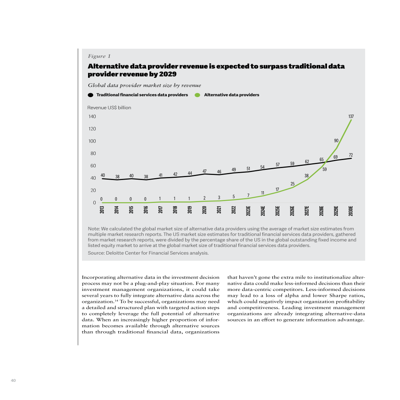

CHUNK 1
	 Generated  Response Text: 
	 ------------------------- 
	 Generated  Response Text:  The figure in search result 3 shows that the global market size (revenue) of alternative data providers is projected to exceed that of traditional financial services data providers starting in 2029, and the gap is expected to widen significantly by 2030.

	 Retrieved References: 
	 ---------------------

		 --> Location: {'s3Location': {'uri': 's3://bedrock-mm-kb-us-west-2-017444429555/DI_FSI-Predictions-2023.pdf'}, 'type': 'S3'}
	
		 --> Metadata: 
			 ---> Source s3://bedrock-mm-kb-us-west-2-017444429555/DI_FSI-Predictions-2023.pdf
	
		
			 ---> x-amz-bedrock-kb-byte-content-source s3://bedrock-mm-storage-bucket-us-west-2-017444429555/aws/bedrock/knowledge_bases/3QNKYFDFSE/XRQ1IQRYSG/94cb3ce6-3d63-4e9b-8ea0-9f2f14a5c86e.png



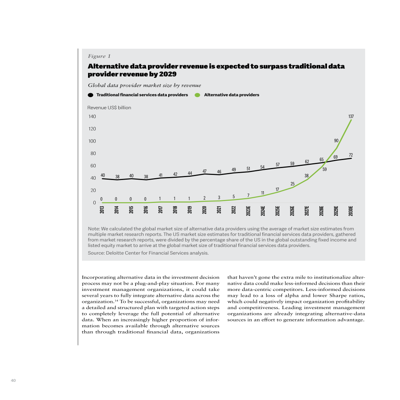

In [38]:
print_response(response)

#### Testing Knowledge Base with Retrieve API
If you need an extra layer of control, you can retrieve the chuncks that best match your query using the retrieve API. In this setup, we can configure the desired number of results and control the final answer with your own application logic. The API then provides you with the matching content, its S3 location, the similarity score and the chunk metadata.

Chunk 1:  

Chunk 1 Location:  {'s3Location': {'uri': 's3://bedrock-mm-kb-us-west-2-017444429555/DI_FSI-Predictions-2023.pdf'}, 'type': 'S3'}

Chunk 1 Score:  0.39821962

Chunk 1 Metadata:  {'x-amz-bedrock-kb-source-uri': 's3://bedrock-mm-kb-us-west-2-017444429555/DI_FSI-Predictions-2023.pdf', 'x-amz-bedrock-kb-description': '<figure>\nFigure 1: Venture capital invested in autonomous trucking, 2016-2022 (in USD)\n| Year | Venture Capital Invested (in USD) |\n|-|-|\n| 2016 | $2.12M |\n| 2017 | $110.04M | \n| 2018 | $213.22M |\n| 2019 | $368.05M |\n| 2020 | $3.70B |\n| 2021 | $3.60B |\n| 2022 | $863.65M |\nNote: Data has not been reviewed by PitchBook analysts in line with PitchBook citation guidelines.\nSource: PitchBook Data, Inc.\n</figure>\nTHE CASE FOR GROWTH OF AUTONOMOUS TRUCKS\nAmong the factors propelling the growth of autonomous trucks, one that stands out is the shortage of human truck drivers in the United States. The American Trucking Association (ATA) reported a driver shor
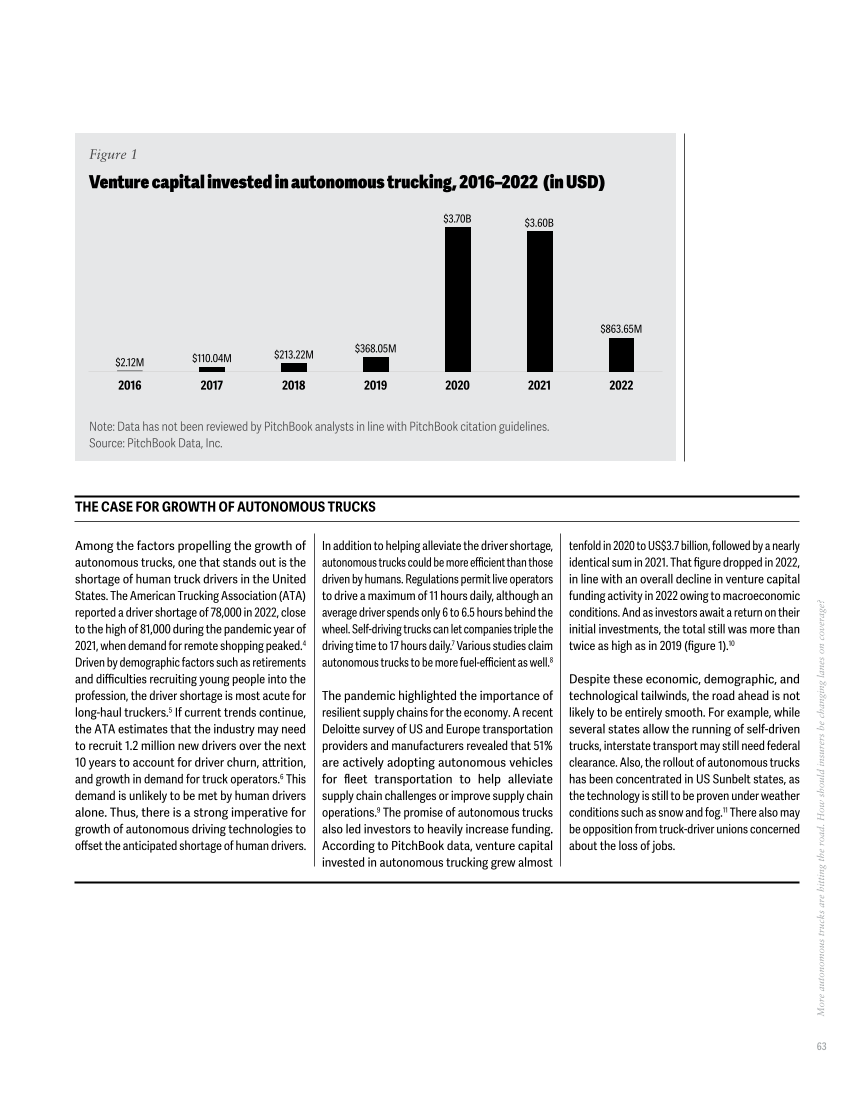

In [39]:
response_ret = bedrock_agent_runtime_client.retrieve(
    knowledgeBaseId=kb_id, 
    nextToken='string',
    retrievalConfiguration={
        "vectorSearchConfiguration": {
            "numberOfResults":5,
        } 
    },
    retrievalQuery={
        "text": "How many new positions were opened across Amazon's fulfillment and delivery network?"
    }
)

def response_print(retrieve_resp):
#structure 'retrievalResults': list of contents. Each list has content, location, score, metadata
    for num,chunk in enumerate(response_ret['retrievalResults'],1):
        if 'text' in chunk['content']:
            print(f'Chunk {num}: ',chunk['content']['text'],end='\n'*2)
        if 'byteContent' in chunk['content']:
            print(f'Chunk {num}: ',chunk['content']['byteContent'],end='\n'*2)
        print(f'Chunk {num} Location: ',chunk['location'],end='\n'*2)
        print(f'Chunk {num} Score: ',chunk['score'],end='\n'*2)
        print(f'Chunk {num} Metadata: ',chunk['metadata'],end='\n'*2)
        print("--------------------------------")

response_print(response_ret)

### Clean up
Please make sure to uncomment and run the below section to delete all the resources.

In [40]:
# Delete KnowledgeBase
for idx, ds in enumerate(data_sources_list):
    bedrock_agent_client.delete_data_source(dataSourceId = ds["dataSourceId"], knowledgeBaseId=kb['knowledgeBaseId'])
bedrock_agent_client.delete_knowledge_base(knowledgeBaseId=kb['knowledgeBaseId'])
oss_client.indices.delete(index=index_name)
aoss_client.delete_collection(id=collection_id)
aoss_client.delete_access_policy(type="data", name=access_policy['accessPolicyDetail']['name'])
aoss_client.delete_security_policy(type="network", name=network_policy['securityPolicyDetail']['name'])
aoss_client.delete_security_policy(type="encryption", name=encryption_policy['securityPolicyDetail']['name'])

{'ResponseMetadata': {'RequestId': '01fa7bd2-24c1-4638-b20d-a4ce38ee1984',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '01fa7bd2-24c1-4638-b20d-a4ce38ee1984',
   'date': 'Tue, 10 Dec 2024 01:01:40 GMT',
   'content-type': 'application/x-amz-json-1.0',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [41]:
# # delete role and policies
from utility import delete_iam_role_and_policies
delete_iam_role_and_policies()

0